#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Validación

 **Objetivos de aprendizaje:**
  * usar varios atributos, en lugar de uno solo, para mejorar aún más la eficacia de un modelo
  * depurar problemas en los datos de entrada del modelo
  * usar un conjunto de datos de prueba para comprobar si un modelo está realizando un sobreajuste en los datos de validación

 Al igual que en los ejercicios anteriores, trabajamos con el conjunto de datos de viviendas en California para intentar predecir `median_house_value` a nivel de manzana en la ciudad a partir de los datos del censo de 1990.

 ## Preparación

 Primero, carguemos y preparemos nuestros datos. Esta vez, trabajaremos con varios atributos, de manera que usaremos un sistema modular en la lógica para procesar los atributos:

In [12]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Ordena los datos de manera aleatoria
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [13]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  # Cra un argumento sintético
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  # Escalca el objetico a unidades de miles de dolares
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

 Para el **conjunto de entrenamiento**, elegiremos los primeros 12,000 ejemplos del total de 17,000.

In [14]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2638.7,538.9,1428.4,500.4,3.9,2.0
std,2.1,2.0,12.6,2207.9,427.3,1176.3,389.2,1.9,1.3
min,32.5,-124.3,2.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1452.0,294.0,786.0,279.0,2.6,1.5
50%,34.2,-118.5,29.0,2114.0,431.0,1160.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3146.0,646.0,1716.2,603.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [15]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.1
std,116.1
min,15.0
25%,119.5
50%,180.1
75%,264.1
max,500.0


 Para el **conjunto de validación**, elegiremos los últimos 5,000 ejemplos del total de 17,000.

In [16]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2655.7,540.6,1432.4,503.2,3.9,2.0
std,2.1,2.0,12.6,2111.5,407.3,1076.6,373.0,1.9,0.9
min,32.6,-124.3,1.0,15.0,3.0,8.0,3.0,0.5,0.0
25%,33.9,-121.8,18.0,1478.0,303.0,798.8,286.0,2.6,1.5
50%,34.3,-118.5,28.5,2164.5,440.0,1185.0,415.0,3.6,2.0
75%,37.7,-118.0,37.0,3161.5,653.2,1735.5,607.2,4.8,2.3
max,42.0,-114.6,52.0,30401.0,4957.0,13251.0,4372.0,15.0,29.4


In [17]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,207.8
std,115.8
min,15.0
25%,119.4
50%,180.6
75%,266.7
max,500.0


 ## Tarea 1: Examina los datos
Observemos los datos que aparecen más arriba. Tenemos `9` atributos de entrada que podemos usar.

Haz una lectura rápida de la tabla de valores. ¿Se ve todo bien? Observa cuántos problemas puedes detectar. No te preocupes si no tienes formación en estadística; el sentido común te llevará lejos.

Una vez que hayas tenido la oportunidad de revisar los datos por tu cuenta, comprueba la solución para obtener otras ideas sobre cómo verificar los datos.

 ### Solución

Haz clic más abajo para conocer la solución.

 Comprobemos nuestros datos con algunas explicaciones de punto de referencia:

* Para algunos valores, como `median_house_value`, podemos ver si estos valores están dentro de rangos razonables (teniendo en cuenta que se trata de datos de 1990, no actuales).

* Para otros valores, como `latitude` y `longitude`, podemos hacer una comprobación rápida para ver si se alinean con los valores esperados a partir de una búsqueda rápida en Google.

Si observas más detenidamente, es posible que detectes algunas singularidades:

* `median_income` está en una escala de aproximadamente 3 a 15. No está claro a qué se refiere esta escala. ¿Tal vez sea una escala logarítmica? No está documentada en ninguna parte; todo lo que podemos suponer es que los valores más altos corresponden a ingresos más altos.

* El `median_house_value` máximo es 500,001. Esto parece un límite artificial de algún tipo.

* Nuestro atributo `rooms_per_person` generalmente está en una escala razonable, con un valor percentil 75º de aproximadamente 2. Pero hay algunos valores muy altos, como 18 o 55, los cuales pueden indicar cierto grado de daño en los datos.

Por el momento, usaremos estos atributos como están. Pero esperamos que estos tipos de ejemplos puedan ayudarte a desarrollar algo de intuición sobre cómo comprobar los datos que llegan a ti de una fuente desconocida.

 ## Tarea 2: Representa latitud/longitud frente a valor mediano de las casas

 Observemos detenidamente dos atributos en particular: **`latitude`** y **`longitude`**. Estas son las coordenadas geográficas de la manzana en cuestión.

Podría parecer una buena visualización; representemos `latitude` y `longitude`, y usemos colores para mostrar el `median_house_value`.

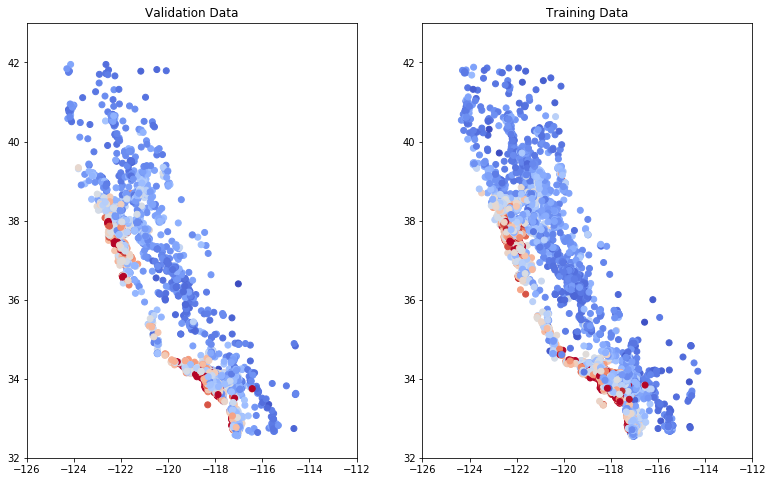

In [18]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

 Espera un momento… Esto nos debería haber dado un hermoso mapa del estado de California, con el color rojo para representar las áreas costosas, como San Francisco y Los Ángeles.

El conjunto de entrenamiento sí lo representa, en comparación con un [mapa real](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55), pero claramente el conjunto de validación no.

**Regresa y vuelve a observar los datos de la Tarea 1.**

¿Puedes ver otras diferencias en las distribuciones de los atributos u objetivos entre los datos de validación y los de entrenamiento?

 ### Solución

Haz clic más abajo para conocer la solución.

 Al observar las tablas de las estadísticas de resumen anteriores, fácilmente te preguntarás cómo se puede hacer una comprobación útil de los datos. ¿Cuál es el valor del percentil 75º para total_rooms por manzana?

El punto clave que se debe observar es que, para cualquier atributo o columna específica, la distribución de los valores entre las divisiones de entrenamiento y validación debe ser casi igual.

El hecho de que esto no sea así es una verdadera preocupación y demuestra que es probable que tengamos una falla en la forma en que se creó nuestra división de entrenamiento y validación.

 ## Tarea 3: Regresa al código de procesamiento previo e importación de datos para ver si se detectan errores
Si detectas errores, soluciónalos. No pases más de un minuto o dos observando. Si no pueden encontrar el error, comprueba la solución.

 Cuando hayas encontrado y solucionado el problema, vuelve a ejecutar la celda de representación de `latitude`/`longitude` anterior y confirma si las comprobaciones de estado dan mejores resultados.

Por cierto, esto representa una lección importante.

**Con frecuencia, la depuración en AA es *depuración de datos* en lugar de depuración de código.**

Si los datos no son correctos, incluso el código de AA más avanzado será incapaz de resolver los problemas.

 ### Solución

Haz clic más abajo para conocer la solución.

 Observa cómo se aleatorizan los datos cuando se leen.

Si no aleatorizamos los datos correctamente antes de crear las divisiones de entrenamiento y validación, es posible que tengamos problemas si los datos se proporcionan en un cierto orden; ese parece ser el caso aquí.

 ## Tarea 4: Entrena y evalua un modelo
**Dedica alrededor de 5 minutos a probar diferentes configuraciones de hiperparámetros. Intenta obtener el mejor rendimiento de validación posible.**
A continuación, entrenaremos un regresor lineal con todos los atributos del conjunto de datos y veremos qué tan bien se desempeña.
Definamos la misma función de entrada que usamos anteriormente para cargar los datos en un modelo de TensorFlow.


In [19]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    # Convierte los datos de pandas en un diccionario de arreglos numpy
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    # Construye un dataset y configura la repetición y procesamiento de lotes
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    # Mezcla los datos, si se específica
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    # Devuelve el siguente lote de datos
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 Como ahora estamos trabajando con varios atributos de entrada, usemos un sistema modular en nuestro código para configurar columnas de atributos en un atributo independiente. (Por ahora, este código es bastante simple, porque todos nuestros atributos son numéricos. Sin embargo, desarrollaremos mejor este código a medida que usemos otros tipos de atributos en ejercicios futuros).

In [20]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

 A continuación, avancemos y completemos el código de `train_model()` más abajo para configurar las funciones de entrada y calcular las predicciones.

**NOTA:** Es correcto hacer referencia al código de los ejercicios anteriores, pero debes asegurarte de invocar `predict()` en los conjuntos de datos adecuados.

Compara las pérdidas en los datos de entrenamiento y los datos de validación. Con un solo atributo sin procesar, nuestro mejor error de la raíz cuadrada de la media (RMSE) fue de alrededor de 180.

Observa cuánto mejora el desempeño ahora que podemos usar atributos múltiples.

Comprueba los datos con alguno de los métodos que observamos antes. Entre estos se incluyen los siguientes:

   * Comparación de distribuciones de predicciones y valores objetivo reales

   * Creación de una representación de dispersión de predicciones frente a valores objetivo

   * Creación de dos representaciones de dispersión de datos de validación con `latitude` y `longitude`:
      * Una representación asigna el color al `median_house_value` objetivo real.
      * Una segunda representación asigna el color al `median_house_value` predicho para la comparación en paralelo.

In [21]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  # Crea un objeto de regresión lineal
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  # Constutruye las columnas de argumentos   
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  # 1. Crea las funciones de entrada
  training_input_fn = # YOUR CODE HERE
  predict_training_input_fn = # YOUR CODE HERE
  predict_validation_input_fn = # YOUR CODE HERE
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  # Entrena el modelo, dentro de un bucle para evaluar las medidas de pérdidas
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    # Entrena el modlo, comenzando desde el estado anterior
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    # 2. 
    training_predictions = # YOUR CODE HERE
    validation_predictions = # YOUR CODE HERE
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

SyntaxError: invalid syntax (<ipython-input-21-35353c255253>, line 44)

In [11]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00001,
    steps=100,
    batch_size=1,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

NameError: name 'train_model' is not defined

 ### Solución

Haz clic más abajo para conocer la solución.

In [22]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 217.35
  period 01 : 199.85
  period 02 : 186.85
  period 03 : 177.01
  period 04 : 171.00
  period 05 : 168.42
  period 06 : 167.34
  period 07 : 167.65
  period 08 : 168.18
  period 09 : 168.79
Model training finished.


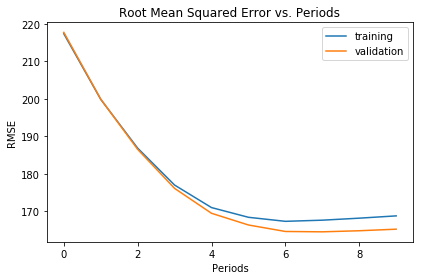

In [23]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Tarea 5: Evalua los datos de prueba

**En la celda a continuación, carga los datos de prueba y evalúa tu modelo con ellos.**

Hemos realizado mucha iteración en nuestros datos de validación. Asegurémonos de no haber sobreajustado las peculiaridades de esa muestra en particular.

El conjunto de datos de prueba está ubicado [aquí](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

¿Cómo se compara el rendimiento de la prueba con el rendimiento de la validación? ¿Qué indica esto sobre el rendimiento de la generalización de tu modelo?

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
#
# YOUR CODE HERE
#

 ### Solución

Haz clic más abajo para conocer la solución.

In [24]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 161.40
